### AI - POWERED REAL-TIME TRAFFIC FLOW OPTIMIZATION USING SENSOR DATA AND MACHINE LEARNING


### DATA UNDERSTANDING

We have two data sets METR-LA.h5 and adj_METR-LA.pkl obtained from kaggle(:https://www.kaggle.com/datasets/annnnguyen/metr-la-dataset?select=adj_METR-LA.pkl)

The METR-LA dataset as DataFrame has:

34,272 rows

207 columns

Data type is float

while  adj_METR-LA.pkl is adj_matrix and it is a list of three elements.

The first element is a list of length 207.

The adj_matrix contain multiple adjacency-related structures.

In [7]:
# Import necessary libraries
import os
import zipfile
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import h5py
import pickle

from pandas.plotting import autocorrelation_plot
from scipy.fftpack import fft
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
import sklearn

# Install required libraries
#!pip install numpy pandas seaborn matplotlib torch h5py pickle-mixin statsmodels scikit-learn

# If using Google Colab or specific PyTorch setup, you may need the following too:
# !pip install torch-geometric torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

# Update scikit-learn
#!pip install -U scikit-learn

# Install PyTorch (if not already installed)
#!pip install torch torchvision torchaudio

# Install PyTorch Geometric and dependencies (compatible with your PyTorch version)
#!pip install torch-geometric torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu118.html


# Extract and Load the Data

In [8]:
#load data
# Load the METR-LA.h5 file
h5_file_path = "/content/METR-LA.h5"

with h5py.File(h5_file_path, "r") as f:
    # List all datasets inside the HDF5 file
    datasets = list(f.keys())

datasets

['df']

In [9]:
# Check the sub-groups inside "df"
with h5py.File(h5_file_path, "r") as f:
    df_subkeys = list(f["df"].keys())

df_subkeys


['axis0', 'axis1', 'block0_items', 'block0_values']

The dataset is stored in a pandas-style format within the HDF5 file, where:

axis0 and axis1 store row and column labels.
block0_items contains column names.
block0_values holds actual data.

In [10]:
#reconstruct the DataFrame
# Load the stored components from the HDF5 file
with h5py.File(h5_file_path, "r") as f:
    axis0 = list(f["df"]["axis0"])  # Row index
    axis1 = list(f["df"]["axis1"])  # Column index
    columns = list(f["df"]["block0_items"])  # Column names
    data_values = f["df"]["block0_values"][:]  # Actual data

# Convert bytes to string for column names
columns = [col.decode("utf-8") if isinstance(col, bytes) else col for col in columns]

# Create a DataFrame
df_reconstructed = pd.DataFrame(data_values, columns=columns)

In [11]:
file_path = '/content/METR-LA.h5'
data_info = df_reconstructed.info()
print(data_info)#data_info
print("\nFirst few rows of the DataFrame:")
data_head = df_reconstructed.head()

data_head #data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34272 entries, 0 to 34271
Columns: 207 entries, 773869 to 769373
dtypes: float64(207)
memory usage: 54.1 MB
None

First few rows of the DataFrame:


,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
0,64.375000,67.625000,67.125000,61.500000,66.875000,68.750000,65.125,67.125,59.625000,62.750000,...,45.625000,65.500,64.500000,66.428571,66.875,59.375000,69.000000,59.250000,69.000000,61.875
1,62.666667,68.555556,65.444444,62.444444,64.444444,68.111111,65.000,65.000,57.444444,63.333333,...,50.666667,69.875,66.666667,58.555556,62.000,61.111111,64.444444,55.888889,68.444444,62.875
2,64.000000,63.750000,60.000000,59.000000,66.500000,66.250000,64.500,64.250,63.875000,65.375000,...,44.125000,69.000,56.500000,59.250000,68.125,62.500000,65.625000,61.375000,69.857143,62.000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000


The METR-LA dataset as DataFrame has:

34,272 rows

207 columns

Data type is float

In [12]:
#load pkl data  and check the data info
# load the adjacency matrix with 'latin1' encoding
path = "/content/adj_METR-LA.pkl"
with open(path, "rb") as f:
    adj_matrix = pickle.load(f, encoding="latin1")

# Check the structure of the adjacency matrix
adj_matrix_shape = adj_matrix.shape if hasattr(adj_matrix, "shape") else None

print(adj_matrix_shape)

None


# DATA CLEANING

#### CHECKING FOR MISSING VALUES

In [13]:
# Check for missing values in the dataset
missing_values = df_reconstructed.isnull().sum().sum()  # Total missing values
missing_per_column = df_reconstructed.isnull().sum().sort_values(ascending=False)  # Missing per column

# Check percentage of missing values
missing_percentage = (missing_values / df_reconstructed.size) * 100

missing_values, missing_percentage, missing_per_column.head(10)


(np.int64(0),
 np.float64(0.0),
 773869    0
 767541    0
 767542    0
 717447    0
 717446    0
 717445    0
 773062    0
 767620    0
 737529    0
 717816    0
 dtype: int64)

Data is clean with no missing values

### EXPLORATORY DATA ANALYSIS

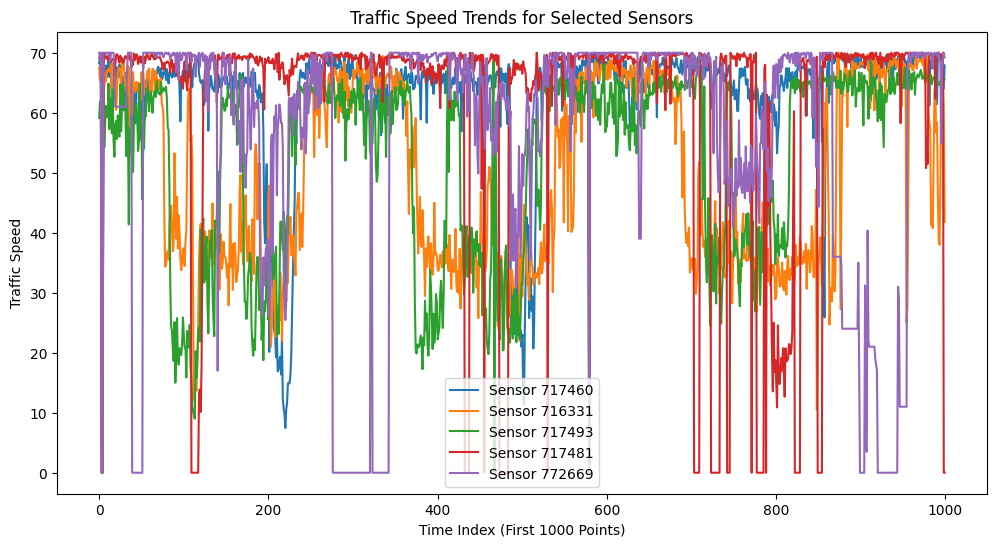

In [14]:
#plotting traffic speed trends for a few randomly selected sensors

# Select a few random sensor columns for visualization
np.random.seed(42)
random_sensors = np.random.choice(df_reconstructed.columns, size=5, replace=False)

# Plot traffic speed trends for selected sensors
plt.figure(figsize=(12, 6))
for sensor in random_sensors:
    plt.plot(df_reconstructed.index[:1000], df_reconstructed[sensor][:1000], label=f"Sensor {sensor}")

plt.xlabel("Time Index (First 1000 Points)")
plt.ylabel("Traffic Speed")
plt.title("Traffic Speed Trends for Selected Sensors")
plt.legend()
plt.show()


There is fluctuations and this indicates changes in traffic flow over time.



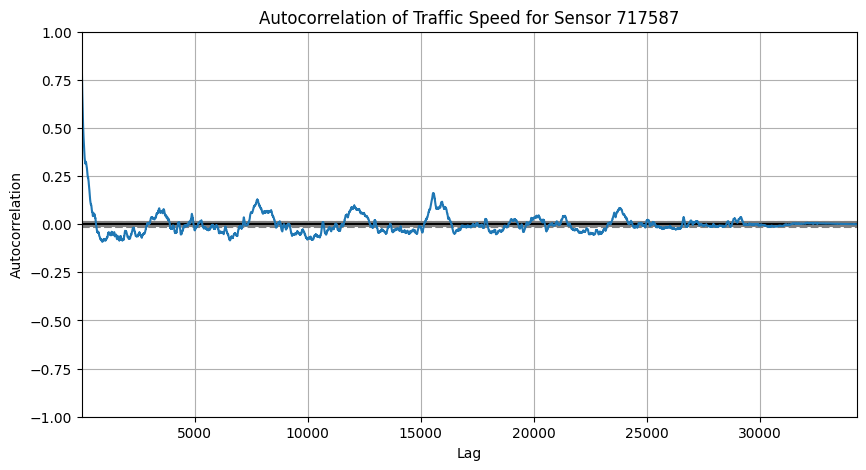

In [15]:
#checking for seasonality in the traffic data

# Select a random sensor to analyze seasonality
sensor_to_analyze = np.random.choice(df_reconstructed.columns)

# Plot autocorrelation for the selected sensor
plt.figure(figsize=(10, 5))
autocorrelation_plot(df_reconstructed[sensor_to_analyze])
plt.title(f"Autocorrelation of Traffic Speed for Sensor {sensor_to_analyze}")
plt.show()


The autocorrelation plot for the sensor 717587 shows repeating peaks, suggesting periodic patterns in traffic speed.

This indicates possible daily or weekly seasonality,

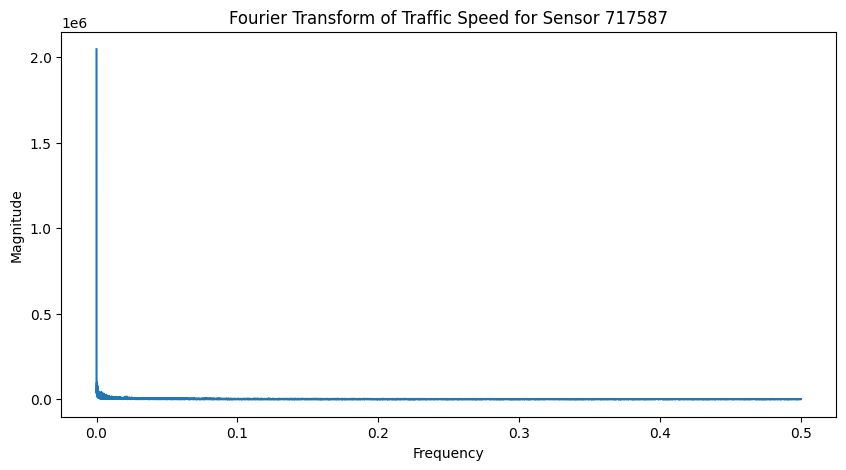

In [16]:
#Confirm seasonality if it is daily or weekly using Fourier Transform

# Select a random sensor for Fourier Transform analysis
sensor_data = df_reconstructed[sensor_to_analyze].dropna().values

# Apply Fast Fourier Transform (FFT)
fft_result = fft(sensor_data)
frequencies = np.fft.fftfreq(len(sensor_data))

# Convert to absolute magnitude for interpretation
magnitude = np.abs(fft_result)

# Plot the frequency spectrum
plt.figure(figsize=(10, 5))
plt.plot(frequencies[:len(frequencies) // 2], magnitude[:len(magnitude) // 2])
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title(f"Fourier Transform of Traffic Speed for Sensor {sensor_to_analyze}")
plt.show()


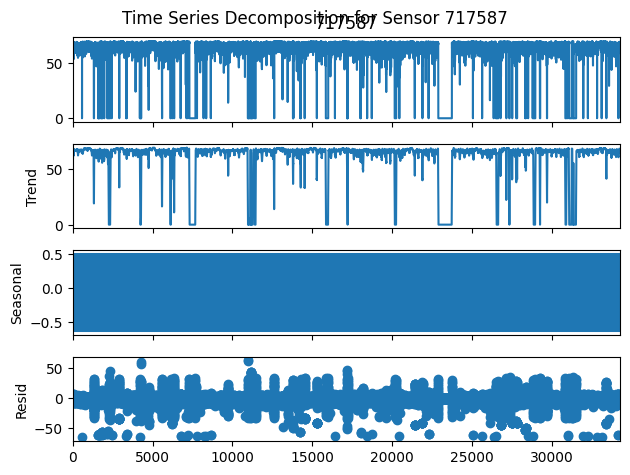

In [17]:
#Plotting a rolling average to visualize trends over time and decomposing the time series.

# Apply a rolling average to smooth the data (window of 24 hours assuming hourly data)
rolling_window = 24  # Adjust based on dataset frequency assumption
df_rolling = df_reconstructed[sensor_to_analyze].rolling(window=rolling_window, center=True).mean()

# Decompose the time series into trend, seasonality, and residuals
decomposition = seasonal_decompose(df_reconstructed[sensor_to_analyze].dropna(), period=rolling_window, model="additive")

# Plot the decomposition of the time series
decomposition.plot()
plt.suptitle(f"Time Series Decomposition for Sensor {sensor_to_analyze}", fontsize=12)
plt.show()


The time series decomposition breaks the traffic speed data into:

Trend: Long-term movement in traffic speed.

Seasonality: Repeating patterns (i.e traffic cycles).

Residuals: Unexplained variations or noise.

This confirms seasonal trends in the dataset.

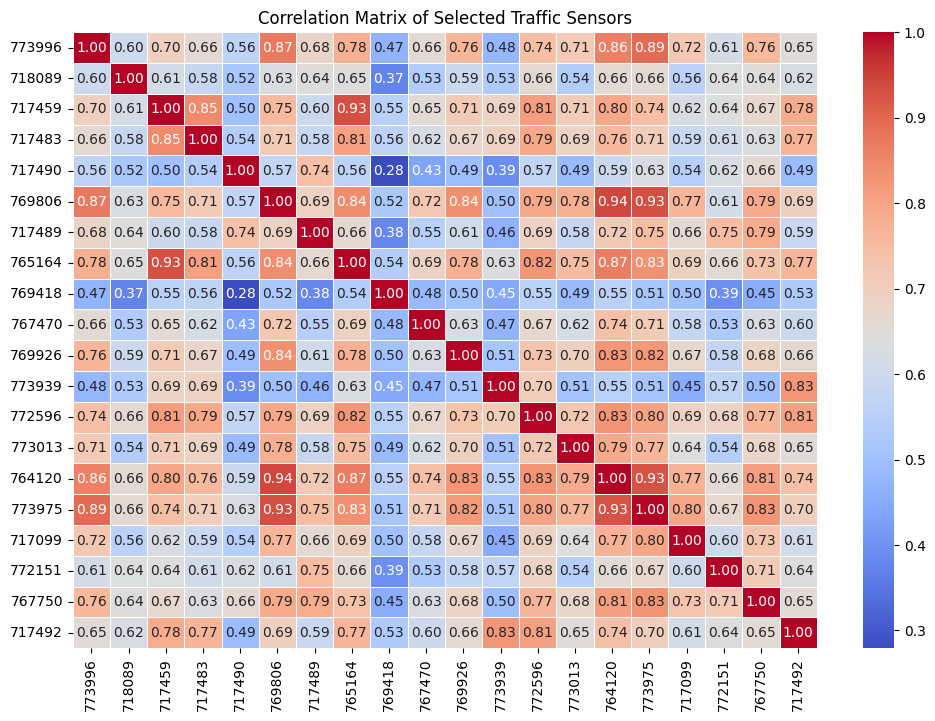

In [18]:
# Correlation analysis between sensors
# Compute correlation matrix for a subset of sensors (to avoid overloading visualization)
num_sensors_to_plot = 20  # Limiting for better visualization
selected_sensors = np.random.choice(df_reconstructed.columns, num_sensors_to_plot, replace=False)

corr_matrix = df_reconstructed[selected_sensors].corr()

# Plot the heatmap with annotation
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Selected Traffic Sensors")
plt.show()



#### DATA PREPROCESSING

#### Feature Engineering
Carrried out the following transformations to make my data ready for modeling

Created time-based features (hour, day of the week).

Generated lag features (previous traffic speeds for prediction).

Aggregate statistics (moving averages, min/max speeds).


In [19]:
# Convert index to datetime if needed (assuming the dataset follows a time order)
df_features = df_reconstructed.copy()
df_features["timestamp"] = pd.to_datetime(df_features.index, unit='s', errors='coerce')

# Extract time-based features
df_features["hour"] = df_features["timestamp"].dt.hour
df_features["day_of_week"] = df_features["timestamp"].dt.dayofweek

# Generate lag features (previous traffic speeds)
lag_steps = [1, 2, 3]  # Lag for 1, 2, and 3 time steps back
for lag in lag_steps:
    df_features[f"lag_{lag}"] = df_features.iloc[:, 0].shift(lag)  # Using first sensor as example

# Compute rolling statistics (moving average, min/max speeds)
rolling_window = 24  # Assuming hourly data, this gives a daily trend
df_features["rolling_mean"] = df_features.iloc[:, 0].rolling(window=rolling_window).mean()
df_features["rolling_min"] = df_features.iloc[:, 0].rolling(window=rolling_window).min()
df_features["rolling_max"] = df_features.iloc[:, 0].rolling(window=rolling_window).max()

# Drop rows with NaN values (due to shifting and rolling operations)
df_features.dropna(inplace=True)

# Display sample data after feature engineering
df_features.head()

#display the last 5 rows
df_features.tail()

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,769373,timestamp,hour,day_of_week,lag_1,lag_2,lag_3,rolling_mean,rolling_min,rolling_max
34267,65.000000,65.888889,68.555556,61.666667,0.0,54.555556,62.444444,63.333333,59.222222,65.333333,...,62.333333,1970-01-01 09:31:07,9,3,62.875,67.625,63.111111,66.411954,62.875,69.0
34268,61.375000,65.625000,66.500000,62.750000,0.0,50.500000,62.000000,67.000000,65.250000,67.125000,...,62.000000,1970-01-01 09:31:08,9,3,65.000,62.875,67.625000,66.094246,61.375,69.0
34269,67.000000,59.666667,69.555556,61.000000,0.0,44.777778,64.222222,63.777778,59.777778,57.666667,...,61.222222,1970-01-01 09:31:09,9,3,61.375,65.000,62.875000,66.130704,61.375,69.0
34270,66.750000,62.250000,66.000000,59.625000,0.0,53.000000,64.285714,64.125000,60.875000,66.250000,...,63.500000,1970-01-01 09:31:10,9,3,67.000,61.375,65.000000,66.138806,61.375,69.0
34271,65.111111,66.888889,66.777778,61.222222,0.0,49.555556,65.777778,65.111111,63.000000,61.666667,...,61.777778,1970-01-01 09:31:11,9,3,66.750,67.000,61.375000,66.069362,61.375,69.0


In [20]:
#Splitting the dataset training (70%), validation (15%), and test (15%) sets.

# Define features (X) and target variable (y) - Using first sensor as the target
X = df_features.drop(columns=["timestamp", df_features.columns[0]])  # Drop timestamp and target
y = df_features.iloc[:, 0]  # First sensor as target variable

# Split into training (70%), validation (15%), and testing (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=False)  # Keep time order
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, shuffle=False)

# Confirm data split sizes
X_train.shape, X_val.shape, X_test.shape


((23974, 214), (5137, 214), (5138, 214))

Training set: 23,974 samples (70%)

Validation set: 5,137 samples (15%)

Test set: 5,138 samples (15%)

### MODELING

#### MODEL 1. RANDOM FOREST REGRESSOR

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time
import numpy as np

# Manually set parameters
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# Train the model
start_time = time.time()
rf_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Latency: prediction time per sample
sample = X_val.iloc[[0]]
latency_list = []
for _ in range(100):
    start = time.time()
    rf_model.predict(sample)
    latency_list.append(time.time() - start)
latency = np.mean(latency_list)

# Throughput: predictions per second
start = time.time()
y_val_pred_rf = rf_model.predict(X_val)
throughput = len(X_val) / (time.time() - start)

# Evaluation
mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
rmse_rf = mean_squared_error(y_val, y_val_pred_rf) ** 0.5

# Results
print(f"Training Time: {training_time:.2f} seconds")
print(f"Latency: {latency:.6f} seconds/sample")
print(f"Throughput: {throughput:.2f} samples/second")
print(f"MAE: {mae_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")


Training Time: 400.14 seconds
Latency: 0.036526 seconds/sample
Throughput: 40242.17 samples/second
MAE: 4.8907
RMSE: 9.7903


The Random Forest model's predictions deviate from the actual values by 4.89 units, and the standard prediction error is 9.79 units

#### MODEL 2. XGBOOST

In [22]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time
import numpy as np

# Manually set parameters
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Train the model
start_time = time.time()
xgb_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Latency: prediction time per sample
sample = X_val.iloc[[0]]
latency_list = []
for _ in range(100):
    start = time.time()
    xgb_model.predict(sample)
    latency_list.append(time.time() - start)
latency = np.mean(latency_list)

# Throughput: predictions per second
start = time.time()
y_val_pred_xgb = xgb_model.predict(X_val)
throughput = len(X_val) / (time.time() - start)

# Evaluation
mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
rmse_xgb = mean_squared_error(y_val, y_val_pred_xgb) ** 0.5

# Results
print(f"Training Time: {training_time:.2f} seconds")
print(f"Latency: {latency:.6f} seconds/sample")
print(f"Throughput: {throughput:.2f} samples/second")
print(f"MAE: {mae_xgb:.4f}")
print(f"RMSE: {rmse_xgb:.4f}")


Training Time: 8.32 seconds
Latency: 0.031537 seconds/sample
Throughput: 76229.31 samples/second
MAE: 4.7175
RMSE: 10.1121


### DEEP LEARNING


#### MODEL 1. GRAPH CONVOLUTIONAL NETWORK AND LONG SHORT-TERM MEMORY (GCN-LSTM)

In [23]:
# Load adjacency matrix

# load the adjacency matrix with 'latin1' encoding
path = "/content/adj_METR-LA.pkl"
with open(path, "rb") as f:
    adj_matrix = pickle.load(f, encoding="latin1")
# Print type and structure to understand what’s inside
print("Type of adj_matrix:", type(adj_matrix))

# If it's a dictionary, check keys
if isinstance(adj_matrix, dict):
    print("Keys:", adj_matrix.keys())

# If it's a NumPy array, check its shape
elif isinstance(adj_matrix, np.ndarray):
    print("Adjacency matrix shape:", adj_matrix.shape)


Type of adj_matrix: <class 'list'>


adj_matrix is a list,I inspect its contents to know how to properly extract the adjacency matrix.

In [24]:
print(f"Length of adj_matrix list: {len(adj_matrix)}")
print(f"Type of first element: {type(adj_matrix[0])}")

# If it's an array, print its shape
if isinstance(adj_matrix[0], np.ndarray):
    print(f"Shape of first element: {adj_matrix[0].shape}")
elif isinstance(adj_matrix[0], torch.Tensor):
    print(f"Shape of first element: {adj_matrix[0].shape}")
elif isinstance(adj_matrix[0], list):
    print(f"Length of first element (list): {len(adj_matrix[0])}")


Length of adj_matrix list: 3
Type of first element: <class 'list'>
Length of first element (list): 207


adj_matrix is a list of three elements

The first element is a list of length 207.

Therefore adj_matrix contain multiple adjacency-related structures.

In [25]:
for i in range(len(adj_matrix)):
    print(f"Type of adj_matrix[{i}]: {type(adj_matrix[i])}")

    # If it's a list, check length
    if isinstance(adj_matrix[i], list):
        print(f"Length of adj_matrix[{i}]: {len(adj_matrix[i])}")

    # If it's an array, check shape
    elif isinstance(adj_matrix[i], np.ndarray):
        print(f"Shape of adj_matrix[{i}]: {adj_matrix[i].shape}")


Type of adj_matrix[0]: <class 'list'>
Length of adj_matrix[0]: 207
Type of adj_matrix[1]: <class 'dict'>
Type of adj_matrix[2]: <class 'numpy.ndarray'>
Shape of adj_matrix[2]: (207, 207)


adj_matrix[0] is a list of length 207

adj_matrix[1] is a dictionary.

adj_matrix[2] is a (207, 207) NumPy adjacency matrix
(this is likely the correct adjacency matrix for the graph).

I go ahead and convert adj_matrix[2] for PyTorch Geometric

In [26]:
from torch_geometric.utils import dense_to_sparse
# Select the adjacency matrix
adj_numpy = adj_matrix[2]

# Convert adjacency matrix to tensor
adj_tensor = torch.tensor(adj_numpy, dtype=torch.float32)

# Convert to edge_index format (sparse representation)
edge_index_tensor, _ = dense_to_sparse(adj_tensor)

print("Edge index shape:", edge_index_tensor.shape)
print("Edge index example:", edge_index_tensor[:, :10])  # Show first 10 edges


Edge index shape: torch.Size([2, 1722])
Edge index example: tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,  13,  37,  42,  54, 111, 116, 125, 140, 142]])


Edge index shape  means there are 1,722 edges in the graph.

In [27]:
from sklearn.preprocessing import MinMaxScaler

# Normalize features using MinMaxScaler (LSTM & GCN require scaled inputs)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors for deep learning models
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Confirm data shape for deep learning models
X_train_tensor.shape, y_train_tensor.shape


(torch.Size([23974, 214]), torch.Size([23974, 1]))

The output confirms that  X_train_tensor has a shape of (23974, 214), meaning 23,974 samples with 214 features each.The y_train_tensor has a shape of (23974, 1), indicating that each sample has a single target value

Epoch 5/50, Loss: 3647.3586
Epoch 10/50, Loss: 3602.6707
Epoch 15/50, Loss: 3496.0825
Epoch 20/50, Loss: 3343.4934
Epoch 25/50, Loss: 3196.9336
Epoch 30/50, Loss: 3069.1865
Epoch 35/50, Loss: 2961.2126
Epoch 40/50, Loss: 2869.8523
Epoch 45/50, Loss: 2790.3313
Epoch 50/50, Loss: 2718.0298


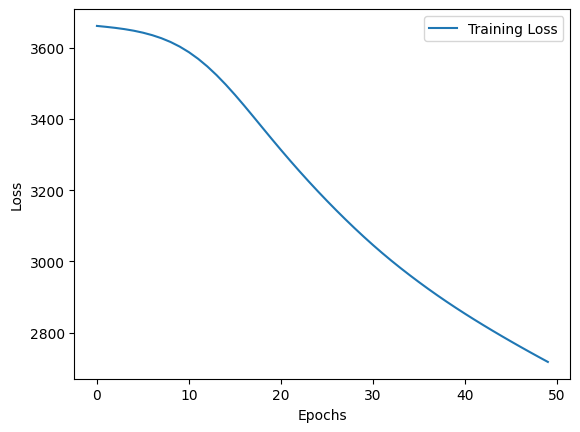

Validation Loss: 2030.3451
MAE: 38.6541, MSE: 2030.3450, RMSE: 45.0593


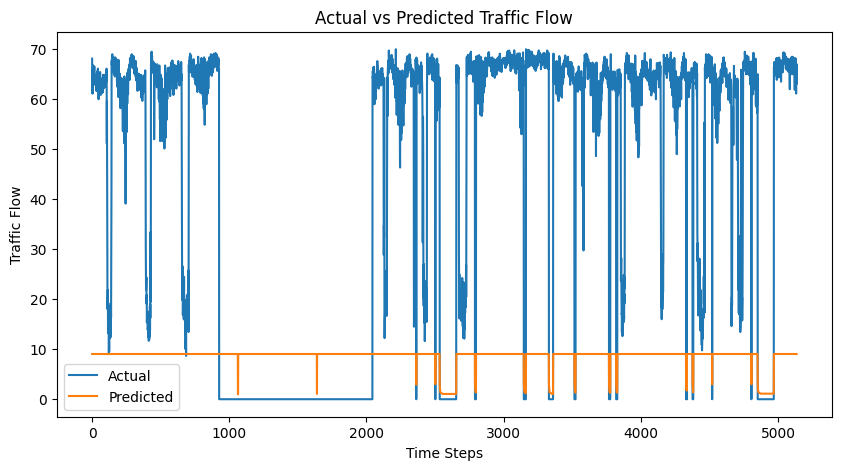

array([[9.043339],
       [9.043375],
       [9.043366],
       ...,
       [9.043359],
       [9.043355],
       [9.043359]], dtype=float32)

In [28]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define GCN-LSTM Model
class GCN_LSTM(nn.Module):
    def __init__(self, num_features, gcn_output_dim, lstm_hidden_dim, num_layers):
        super(GCN_LSTM, self).__init__()

        # Graph Convolutional Layers
        self.gcn1 = GCNConv(num_features, gcn_output_dim)
        self.gcn2 = GCNConv(gcn_output_dim, gcn_output_dim)

        # LSTM Layer
        self.lstm = nn.LSTM(input_size=gcn_output_dim,
                            hidden_size=lstm_hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)

        # Fully connected output layer
        self.fc = nn.Linear(lstm_hidden_dim, 1)

    def forward(self, x, edge_index):
        # GCN Layers
        x = torch.relu(self.gcn1(x, edge_index))
        x = torch.relu(self.gcn2(x, edge_index))

        # Reshape for LSTM (Batch, Time Steps, Features)
        x = x.unsqueeze(1)  # Adding time-step dimension

        # LSTM Forward Pass
        lstm_out, _ = self.lstm(x)

        # Fully connected output
        out = self.fc(lstm_out[:, -1, :])  # Use last LSTM output
        return out

# Model hyperparameters
num_features = X_train.shape[1]  # Input feature size
gcn_output_dim = 64  # GCN output dimensions
lstm_hidden_dim = 128  # LSTM hidden units
num_layers = 2  # Number of LSTM layers

# Initialize model
model = GCN_LSTM(num_features, gcn_output_dim, lstm_hidden_dim, num_layers)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Ensure edge_index is in the correct dtype
edge_index_tensor = edge_index_tensor.to(device).long()

# Training loop
def train_model(model, X_train, y_train, edge_index, optimizer, criterion, num_epochs=50):
    model.train()  # Set model to training mode
    train_losses = []

    for epoch in range(num_epochs):
        X_train, y_train = X_train.to(device), y_train.to(device)
        edge_index = edge_index.to(device).long()

        optimizer.zero_grad()  # Reset gradients
        output = model(X_train, edge_index)  # Forward pass
        loss = criterion(output, y_train)  # Compute loss

        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        train_losses.append(loss.item())

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

    # Plot training loss
    plt.plot(range(num_epochs), train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Evaluation function
def evaluate_model(model, X_val, y_val, edge_index, criterion):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        X_val, y_val = X_val.to(device), y_val.to(device)
        edge_index = edge_index.to(device).long()

        y_pred = model(X_val, edge_index)
        val_loss = criterion(y_pred, y_val)

    print(f"Validation Loss: {val_loss.item():.4f}")

    # Convert predictions to NumPy for evaluation
    y_pred_np = y_pred.cpu().numpy()
    y_val_np = y_val.cpu().numpy()

    # Compute evaluation metrics
    mae = mean_absolute_error(y_val_np, y_pred_np)
    mse = mean_squared_error(y_val_np, y_pred_np)
    rmse = np.sqrt(mse)

    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(y_val_np, label='Actual')
    plt.plot(y_pred_np, label='Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel('Traffic Flow')
    plt.legend()
    plt.title('Actual vs Predicted Traffic Flow')
    plt.show()

    return y_pred_np

# Train the model
train_model(model, X_train_tensor, y_train_tensor, edge_index_tensor, optimizer, criterion, num_epochs=50)

# Evaluate the model
evaluate_model(model, X_val_tensor, y_val_tensor, edge_index_tensor, criterion)


Training loss is decreasing, which indicates that the model is learning, but the validation loss is still high, and the predictions is very close to a single value (~9.21107) for all test samples.
There is potential issues with model convergence or improper learning.

let us try and iprove the model

#### Improving model convergence and improper learning
#### MODEL 2. GRAPH CONVOLUTIONAL NETWORK AND LONG SHORT-TERM MEMORY (GCN-LSTM)

Training started...
Epoch 5/50, Loss: 0.5781
Epoch 10/50, Loss: 0.1357
Epoch 15/50, Loss: 0.1164
Epoch 20/50, Loss: 0.1309
Epoch 25/50, Loss: 0.1288
Epoch 30/50, Loss: 0.1090
Epoch 35/50, Loss: 0.1036
Epoch 40/50, Loss: 0.1039
Epoch 45/50, Loss: 0.1042
Epoch 50/50, Loss: 0.1039

✅ Total Training Time: 625.37 seconds



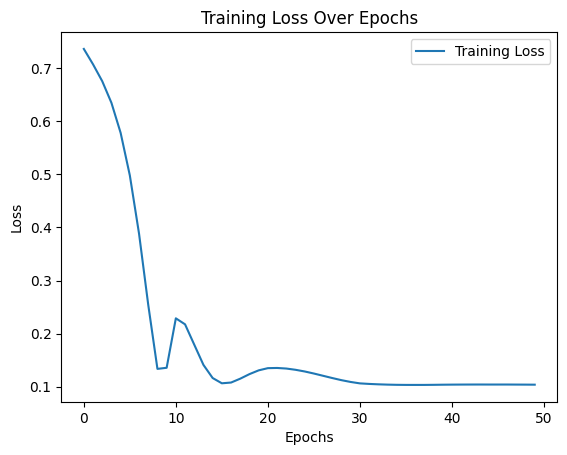

✅ Inference Latency (avg per sample): 0.000090 seconds
✅ Throughput: 11058.28 samples/second
Validation Loss: 0.2404
MAE: 20.2836, MSE: 920.4960, RMSE: 30.3397


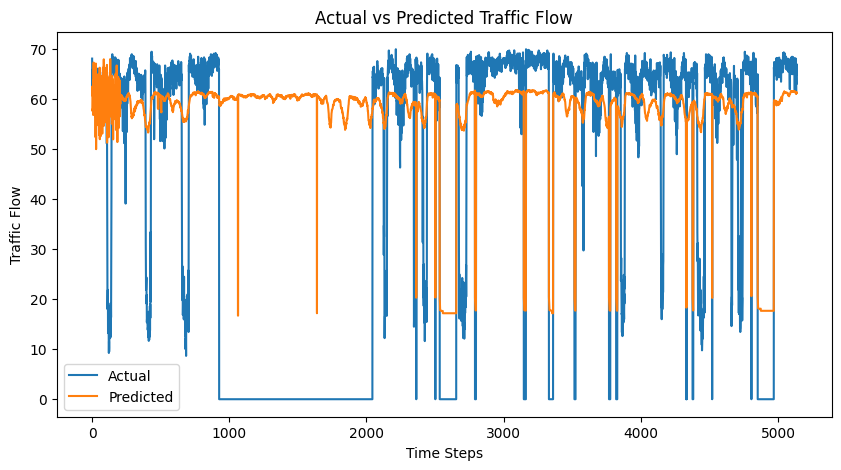

array([[60.81111 ],
       [62.54893 ],
       [62.057774],
       ...,
       [61.320915],
       [61.164665],
       [61.337837]], dtype=float32)

In [29]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Normalizing Features and Target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).unsqueeze(1)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
X_val_tensor, y_val_tensor = X_val_tensor.to(device), y_val_tensor.to(device)
X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)

# Define GCN-LSTM Model
class GCN_LSTM(nn.Module):
    def __init__(self, num_features, gcn_output_dim, lstm_hidden_dim, num_layers):
        super(GCN_LSTM, self).__init__()

        self.gcn1 = GCNConv(num_features, gcn_output_dim)
        self.gcn2 = GCNConv(gcn_output_dim, gcn_output_dim)

        self.lstm = nn.LSTM(
            input_size=gcn_output_dim,
            hidden_size=lstm_hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )

        self.fc = nn.Linear(lstm_hidden_dim, 1)

    def forward(self, x, edge_index):
        x = torch.relu(self.gcn1(x, edge_index))
        x = torch.relu(self.gcn2(x, edge_index))
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Model parameters
num_features = X_train.shape[1]
gcn_output_dim = 128
lstm_hidden_dim = 256
num_layers = 3

# Initialize model
model = GCN_LSTM(num_features, gcn_output_dim, lstm_hidden_dim, num_layers).to(device)

# Loss, optimizer, scheduler
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training function with training time tracking
def train_model(model, X_train, y_train, edge_index, num_epochs=50):
    model.train()
    train_losses = []

    print("Training started...")
    start_time = time.time()

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(X_train, edge_index.to(device))
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_losses.append(loss.item())

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

    end_time = time.time()
    total_training_time = end_time - start_time
    print(f"\n✅ Total Training Time: {total_training_time:.2f} seconds\n")

    # Plot training loss
    plt.plot(range(num_epochs), train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss Over Epochs')
    plt.show()

# Evaluation function with latency and throughput
def evaluate_model(model, X_val, y_val, edge_index):
    model.eval()
    with torch.no_grad():
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        edge_index = edge_index.to(device)

        # Measure inference time
        start_time = time.time()
        y_pred = model(X_val, edge_index)
        end_time = time.time()

        # Latency and throughput
        latency = (end_time - start_time) / X_val.shape[0]
        throughput = X_val.shape[0] / (end_time - start_time)

        print(f"✅ Inference Latency (avg per sample): {latency:.6f} seconds")
        print(f"✅ Throughput: {throughput:.2f} samples/second")

        val_loss = criterion(y_pred, y_val)
        print(f"Validation Loss: {val_loss.item():.4f}")

        # Convert predictions to original scale
        y_pred_np = scaler_y.inverse_transform(y_pred.cpu().numpy())
        y_val_np = scaler_y.inverse_transform(y_val.cpu().numpy().squeeze(-1))

        # Evaluation metrics
        mae = mean_absolute_error(y_val_np, y_pred_np)
        mse = mean_squared_error(y_val_np, y_pred_np)
        rmse = np.sqrt(mse)
        print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")

        # Plot predictions
        plt.figure(figsize=(10, 5))
        plt.plot(y_val_np, label='Actual')
        plt.plot(y_pred_np, label='Predicted')
        plt.xlabel('Time Steps')
        plt.ylabel('Traffic Flow')
        plt.legend()
        plt.title('Actual vs Predicted Traffic Flow')
        plt.show()

        return y_pred_np

# Run training and evaluation
train_model(model, X_train_tensor, y_train_tensor, edge_index_tensor, num_epochs=50)
evaluate_model(model, X_val_tensor, y_val_tensor, edge_index_tensor)
